# OPTIMIZATION PROJECT

Kaan Yücel - 150210318 
Emir Zal Öztunç - 150210334 
Ulus Emir Aslan - 150210320

### Data Preprocessing

In [1]:
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# Read the data
csv_file_path = "nutrients_csvfile.csv"
df = pd.read_csv(csv_file_path)

In [3]:
df = df[["Food","Grams","Calories","Protein","Fat","Carbs","Category"]]
# Dataset includes various kinds of foods but selection below is good part to work on
chosen_food= [0,10,14,18,26,29,38,43,44,45,48,55,69,84,90,93,101,105,
              113,115,124,125,128,146,155,164,171,186,215,218,221,
              240,243,247,255,276,283,292,296,316,325]

In [4]:
df = df.iloc[chosen_food, :].reset_index(drop=True)
# t values indicates trace amount so we replaced it by 0 
df.replace("t", 0, inplace=True)
# Convert values to float
df[['Calories', 'Protein', 'Fat', 'Carbs', 'Grams']] = df[['Calories', 'Protein', 'Fat', 'Carbs', 'Grams']].astype(float)

In [5]:
# To categorize the rows better, we apply this operation
df['Category'] = df['Category'].apply(lambda x: x.replace(',', ' ').split()[0])
df

,Food,Grams,Calories,Protein,Fat,Carbs,Category
0,Cows' milk,976.0,660.0,32.0,40.0,48.0,Dairy
1,Cocoa,252.0,235.0,8.0,11.0,26.0,Dairy
2,Ice cream,188.0,300.0,6.0,18.0,29.0,Dairy
3,Cheese,225.0,240.0,30.0,11.0,6.0,Dairy
4,Eggs raw,100.0,150.0,12.0,12.0,0.0,Dairy
5,Butter,14.0,100.0,0.0,11.0,0.0,Fats
6,Olive oil,14.0,125.0,0.0,14.0,0.0,Fats
7,Bacon,16.0,95.0,4.0,8.0,1.0,Meat
8,Beef,85.0,245.0,23.0,16.0,0.0,Meat
9,Hamburger,85.0,245.0,21.0,17.0,0.0,Meat


In [6]:
# Calories/protein/carbs/fat per 1 gram
df['Calories'] = (df['Calories'] / df['Grams'])
df['Protein'] = (df['Protein'] / df['Grams']) 
df['Carbs'] = (df['Carbs'] / df['Grams']) 
df['Fat'] = (df['Fat'] / df['Grams']) 

# Since we are going to be using integer programming we arranged the base value of grams 
# to a certain value depends on the category of the food.For instance, one can eat only 0,
#50,100 .. grams of steak.In the other hand, can eat 0,20,40... grams of banana.

included_categories = ['Meat', 'Fish', 'Dairy', 'Breads']
df.loc[df['Category'].isin(included_categories), ['Protein','Fat','Calories','Carbs']] *= 50
df.loc[df['Category'].isin(included_categories), ['Grams']] = 50

included_categories = ['Vegetables', 'Fruits','Desserts','Jams','Seeds','Drinks']
df.loc[df['Category'].isin(included_categories), ['Protein','Fat','Calories','Carbs']] *= 20
df.loc[df['Category'].isin(included_categories), ['Grams']]= 20

df.loc[(df['Category'] == 'Fats'), ['Protein','Fat','Calories','Carbs']] *= 10
df.loc[(df['Category'] == 'Fats'), ['Grams']] = 10

df=df.round(2)
df

,Food,Grams,Calories,Protein,Fat,Carbs,Category
0,Cows' milk,50.0,33.81,1.64,2.05,2.46,Dairy
1,Cocoa,50.0,46.63,1.59,2.18,5.16,Dairy
2,Ice cream,50.0,79.79,1.60,4.79,7.71,Dairy
3,Cheese,50.0,53.33,6.67,2.44,1.33,Dairy
4,Eggs raw,50.0,75.00,6.00,6.00,0.00,Dairy
5,Butter,10.0,71.43,0.00,7.86,0.00,Fats
6,Olive oil,10.0,89.29,0.00,10.00,0.00,Fats
7,Bacon,50.0,296.88,12.50,25.00,3.12,Meat
8,Beef,50.0,144.12,13.53,9.41,0.00,Meat
9,Hamburger,50.0,144.12,12.35,10.00,0.00,Meat


### Integer Programming

In [7]:
# Thresholds are taken from the website provided in the project proposal,
#we will experiment of different kinds of thresholds later in the project
#First element of the list represents the amount of protein,second is fat
# and the last represents the carbs that minimum amount must consumed.
thresholds_man_average = [55,95,300]
thresholds_women_average =[50,70,260]

In [8]:
calories = df['Calories'].values
total_protein = df['Protein'].values
total_fat = df['Fat'].values
total_carbs = df['Carbs'].values

In [9]:
# Indices for constraint operations
meat_indices = df[df['Category'] == 'Meat'].index
vegetable_indices = df[df['Category'] == 'Vegetable'].index
dairy_indices = df[df['Category'] == 'Dairy'].index
jams_indices = df[df['Category'] == 'Jams'].index
dessert_indices = df[df['Category'] == 'Desserts'].index
drink_indices = df[df['Category'] == 'Drink'].index

Implementation of linear programming

In [10]:
def linear_programming(threshold,c,int_flag): 
    # threshold: threshold for protein,fat and carb
    # c: hyperparameter for limiting the person to consume one food too much
    # int_flag: boolean value that represents if the linear programming
    # method is integer programming or not 
   
    food_vars = cp.Variable(len(df), integer=int_flag)
    objective = cp.Minimize(calories @ food_vars)
    
    # We have 5 contraints here 3 of them are what we spoke of before.
    # One of the other two is each parameter should be greater or 
    # equal to zero and the last is for prevent the person to consume
    # one food too much.
    
    constraints = [
        total_protein @ food_vars >= threshold[0],
        total_fat @ food_vars >= threshold[1],
        total_carbs @ food_vars >= threshold[2],
        food_vars >= 0,
    ]
    for var in food_vars:
        constraints.append(var <= c)
    # Solving the problem
    prob = cp.Problem(objective, constraints)
    optimal_calorie=prob.solve()
    print("Optimal value of calories:",optimal_calorie)
    print("Status:", prob.status)
    optimal_values = food_vars.value
    for food,gram, val in zip(df['Food'],df['Grams'], optimal_values):
        if val > 0.1 : 
            print(f"{food}: {val*gram:.2f} grams")
    return optimal_calorie

### Experiments with different hyperparameters

We will experiment with c values that explained in the function above,different thresholds and different int_flag values which represents either we are conducting integer programming or linear programming.

We will experiment on 2 different thresholds which are threshold for women and man.
Let's start with the threshold for man.

In [11]:
experiment=[]

In [12]:
threshold=thresholds_man_average
c=5
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 2154.54
Status: optimal
Cows' milk: 50.00 grams
Olive oil: 40.00 grams
Beans: 100.00 grams
Broccoli: 100.00 grams
Carrots: 20.00 grams
Corn: 100.00 grams
Mushrooms canned: 100.00 grams
Onions: 60.00 grams
Apples, raw: 100.00 grams
Banana: 100.00 grams
Strawberries: 20.00 grams
Watermelon: 40.00 grams
Bread, cracked wheat: 250.00 grams
Oatmeal: 100.00 grams
Jellies: 100.00 grams
Peanut butter: 80.00 grams


In [13]:
threshold=thresholds_man_average
c=10
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 2115.4500000000003
Status: optimal
Eggs raw: 50.00 grams
Olive oil: 70.00 grams
Beans: 200.00 grams
Broccoli: 80.00 grams
Corn: 160.00 grams
Mushrooms canned: 200.00 grams
Tomatoes: 20.00 grams
Banana: 200.00 grams
Watermelon: 180.00 grams
Bread, cracked wheat: 400.00 grams


In [14]:
threshold=thresholds_man_average
c=20
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie])  

Optimal value of calories: 2079.55
Status: optimal
Cows' milk: 100.00 grams
Olive oil: 80.00 grams
Beans: 400.00 grams
Broccoli: 400.00 grams
Corn: 400.00 grams
Mushrooms canned: 400.00 grams
Apples, raw: 20.00 grams
Banana: 400.00 grams
Grapes: 20.00 grams
Watermelon: 400.00 grams
Bread, cracked wheat: 150.00 grams


In [15]:
threshold=thresholds_man_average
c=5
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie])  

Optimal value of calories: 2149.5858826356393
Status: optimal
Olive oil: 34.60 grams
Beans: 100.00 grams
Broccoli: 100.00 grams
Corn: 100.00 grams
Mushrooms canned: 100.00 grams
Apples, raw: 100.00 grams
Banana: 100.00 grams
Strawberries: 76.59 grams
Watermelon: 100.00 grams
Bread, cracked wheat: 250.00 grams
Jellies: 100.00 grams
Peanut butter: 96.90 grams


In [16]:
threshold=thresholds_man_average
c=10
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie])  

Optimal value of calories: 2109.565071443857
Status: optimal
Eggs raw: 27.95 grams
Olive oil: 73.31 grams
Beans: 200.00 grams
Broccoli: 200.00 grams
Corn: 200.00 grams
Mushrooms canned: 200.00 grams
Banana: 200.00 grams
Watermelon: 200.00 grams
Bread, cracked wheat: 371.79 grams


In [17]:
threshold=thresholds_man_average
c=20
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie])  

Optimal value of calories: 2076.115754261915
Status: optimal
Eggs raw: 14.40 grams
Olive oil: 81.55 grams
Beans: 400.00 grams
Broccoli: 400.00 grams
Corn: 400.00 grams
Mushrooms canned: 400.00 grams
Banana: 400.00 grams
Watermelon: 400.00 grams
Bread, cracked wheat: 168.65 grams


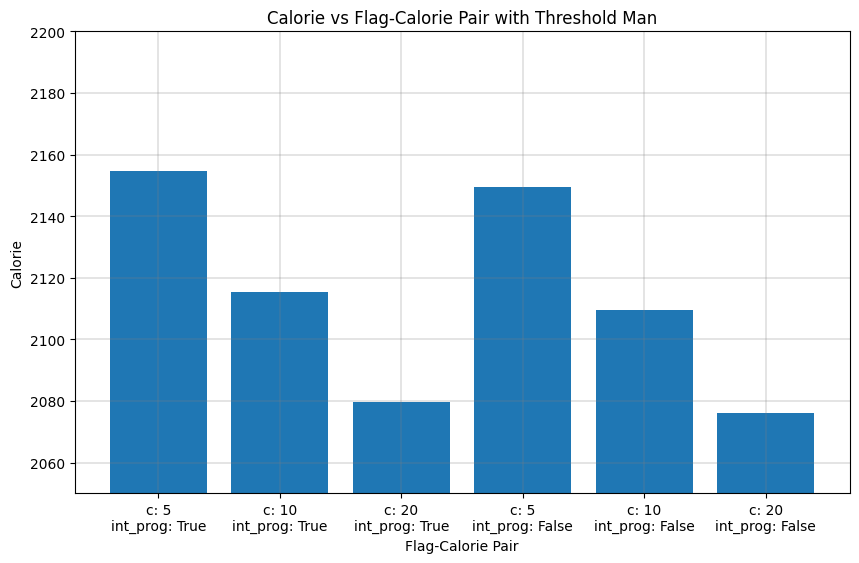

In [18]:

x_values = [f"c: {row[1]}\nint_prog: {row[2]}" for row in experiment]
y_values = [row[3] for row in experiment]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values)
plt.xlabel('Flag-Calorie Pair')
plt.ylabel('Calorie')
plt.title('Calorie vs Flag-Calorie Pair with Threshold Man')
plt.ylim(2050, 2200)  # Setting y-axis limits

plt.grid(True, color='gray', linewidth=.3) 
# Display the plot
plt.show() 


Let's go on with the threshold for women.

In [19]:
experiment=[]

In [20]:
threshold=thresholds_women_average
c=5
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1755.9100000000003
Status: optimal
Cows' milk: 200.00 grams
Eggs raw: 100.00 grams
Butter: 10.00 grams
Olive oil: 30.00 grams
Beans: 100.00 grams
Broccoli: 100.00 grams
Corn: 100.00 grams
Mushrooms canned: 100.00 grams
Onions: 20.00 grams
Banana: 100.00 grams
Watermelon: 100.00 grams
Bread, cracked wheat: 250.00 grams
Jellies: 100.00 grams


In [21]:
threshold=thresholds_women_average
c=10
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1728.0700000000002
Status: optimal
Ice cream: 50.00 grams
Olive oil: 40.00 grams
Beans: 40.00 grams
Broccoli: 200.00 grams
Corn: 200.00 grams
Mushrooms canned: 200.00 grams
Banana: 160.00 grams
Watermelon: 200.00 grams
Bread, cracked wheat: 300.00 grams
Peanut butter: 20.00 grams


In [22]:
threshold=thresholds_women_average
c=20
flag=True
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1695.27
Status: optimal
Olive oil: 50.00 grams
Beans: 220.00 grams
Broccoli: 320.00 grams
Corn: 340.00 grams
Mushrooms canned: 400.00 grams
Banana: 400.00 grams
Watermelon: 140.00 grams
Bread, cracked wheat: 150.00 grams
Peanut butter: 20.00 grams


In [23]:
threshold=thresholds_women_average
c=5
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1751.848931554292
Status: optimal
Olive oil: 19.30 grams
Beans: 100.00 grams
Broccoli: 100.00 grams
Corn: 100.00 grams
Mushrooms canned: 100.00 grams
Banana: 100.00 grams
Watermelon: 100.00 grams
Bread, cracked wheat: 250.00 grams
Jellies: 96.31 grams
Peanut butter: 77.50 grams


In [24]:
threshold=thresholds_women_average
c=10
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1722.0378206351158
Status: optimal
Eggs raw: 41.86 grams
Olive oil: 49.97 grams
Beans: 200.00 grams
Broccoli: 200.00 grams
Corn: 200.00 grams
Mushrooms canned: 200.00 grams
Banana: 200.00 grams
Watermelon: 200.00 grams
Bread, cracked wheat: 295.13 grams


In [25]:
threshold=thresholds_women_average
c=20
flag=False
calorie=linear_programming(threshold,c,flag)
experiment.append([threshold,c,flag,calorie]) 

Optimal value of calories: 1688.588502824182
Status: optimal
Eggs raw: 28.31 grams
Olive oil: 58.21 grams
Beans: 400.00 grams
Broccoli: 400.00 grams
Corn: 400.00 grams
Mushrooms canned: 400.00 grams
Banana: 400.00 grams
Watermelon: 400.00 grams
Bread, cracked wheat: 91.99 grams


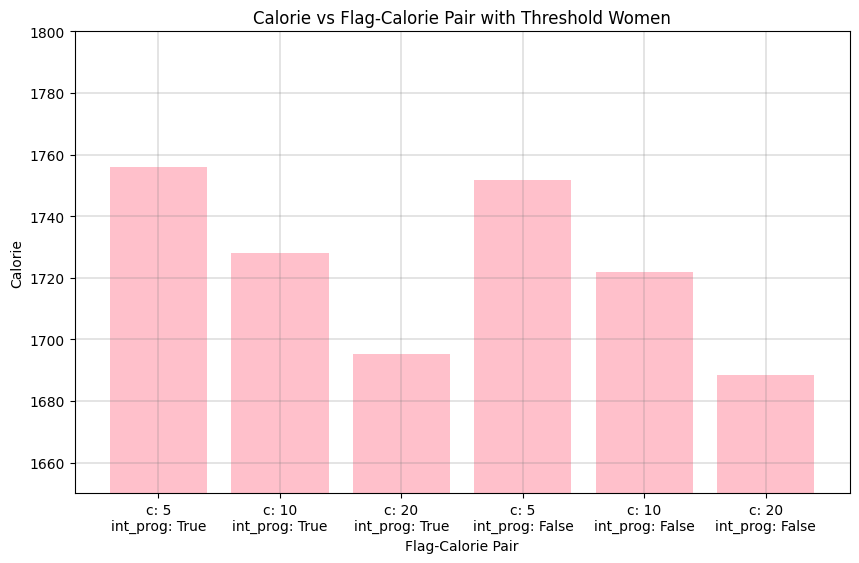

In [26]:
x_values = [f"c: {row[1]}\nint_prog: {row[2]}" for row in experiment]
y_values = [row[3] for row in experiment]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values,color="pink")
plt.xlabel('Flag-Calorie Pair')
plt.ylabel('Calorie')
plt.title('Calorie vs Flag-Calorie Pair with Threshold Women')
plt.ylim(1650, 1800)  # Setting y-axis limits

plt.grid(True, color='gray', linewidth=.3) 
# Display the plot
plt.show() 
